## Importations

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as sql
import configparser
import datetime
import seaborn as sns
import matplotlib.pyplot as plt 
import io
import boto3
import json
import matplotlib.pyplot as plt

## Configuration

In [2]:
config = configparser.ConfigParser()
config.read('../config/default.ini')

['../config/default.ini']

In [3]:
db = 'DATABASE'

In [4]:
engine_redshift = sql.create_engine('postgresql://{}:{}@{}:{}/{}'.format(config[db]['username'], config[db]['password'].replace('_percentage_', '%'), config[db]['host'], config[db]['port'], config[db]['database']),pool_recycle=600)

In [5]:
config = configparser.ConfigParser()
config.read('../config/reco.ini')

['../config/reco.ini']

In [6]:
db = 'DB_DEV'

In [7]:
engine = sql.create_engine('postgresql://{}:{}@{}:{}/{}'.format(config[db]['username'], config[db]['password'], config[db]['host'], config[db]['port'], config[db]['database']),pool_recycle=600)

In [8]:
db = 'DB_PROD'

In [9]:
engine_prod = sql.create_engine('postgresql://{}:{}@{}:{}/{}'.format(config[db]['username'], config[db]['password'], config[db]['host'], config[db]['port'], config[db]['database']),pool_recycle=600)

## Utilitaires

In [10]:
def export_df(df, name, date=True):
    df.to_csv('../output/{}{}.csv'.format('{}_'.format(datetime.datetime.strftime(datetime.datetime.now(), '%y%m%d')) if date else '', name), index=False, encoding='utf-8-sig')

In [11]:
def export_fig(plot, name, date=True):
    plot.savefig('../images/{}{}.png'.format('{}_'.format(datetime.datetime.strftime(datetime.datetime.now(), '%y%m%d')) if date else '', name))

In [12]:
def get_differences(k, node1, node2):
    dif = {}
    if not type(node1) == dict:
        if node1 != node2:
            dif = {
                'prev': node1,
                'cur': node2
            }
    else:
        keys = set(list(node1.keys()) + list(node2.keys()))
        for key in keys:
            if key in node1 and key in node2:
                cur_dif = get_differences(key, node1[key], node2[key])
                if len(cur_dif.keys()) > 0:
                    dif[key]= cur_dif
            else:
                if (node1[key] != '' if key in node1 else np.nan or node2[key] != '' if key in node2 else np.nan):
                    dif[key] = {
                        'prev': node1[key] if key in node1 else np.nan,
                        'cur': node2[key] if key in node2 else np.nan
                    }
    return dif

In [13]:
def add_elem_changed(elem, elems_changed):
    elems_changed[elem] += 1

In [14]:
def calculate_differences(element):
    prev = 0 if not 'prev' in element or element['prev'] != element['prev'] else element['prev'] if type(element['prev']) in [float, datetime.date] else len(element['prev']) if type(element['prev']) in [list, str] else len(element['prev'].keys()) if type(element['prev']) == dict else 0
    cur = 0 if not 'cur' in element or element['cur'] != element['cur'] else element['cur'] if type(element['cur']) in [float, datetime.date] else len(element['cur']) if type(element['cur']) in [list, str] else len(element['cur'].keys()) if type(element['cur']) == dict else 0
    try:
        dif = cur-prev
    except:
        return 0
    if type(dif) == datetime.timedelta:
        return dif.days
    return dif

## Données

### Media in Auvio and mongo and not in Data reco

In [15]:
df_media_mongo = pd.read_csv('/home/meili/OneDrive/Documents/02_gestion_donnees/02_Données/03_Transformation/Results/210617_medias_mongo.csv')
df_media_mongo.head()

_id  mediaId
0  5eb17c4b6971fe000837811b  2356889
1  5eb17c5e6971fe0008398193  1811686
2  5eb17c406971fe00083676eb  2125555
3  5eb17c3e6971fe0008363916  2532351
4  5eb17c3c6971fe0008360e82  2489763

In [16]:
df_redshift = pd.read_sql_query("""select mo.id,mo.created,'redshift' as database,mo.live_from,mo.live_until,mo.active,mo.status,mo.provider from media_objects mo inner join media_programs mp on mo.program_id = mp.id where mo.live_from < current_date and mo.live_until > date_add('day',1,current_date) and mo.active = '1' and mp.publish = '1' and mo.provider in ('AREMA','CHAPTERAUTO','CHAPTERCMS','CRYO','DALET','LIVECENTER','NETIA','SONUMA','WHATSON') ORDER BY mo.created""", engine_redshift)
df_redshift['id'] = df_redshift['id'].astype(int)

In [17]:
df_data_reco = pd.read_sql_query("""select id,'datareco' as database from rtbfv2.media where created_date > '2020-12-20' OR updated_date > '2020-12-20'""", engine)
df_data_reco['id'] = df_data_reco['id'].astype(int)

In [18]:
export_df(df_data_reco, 'media_recommendable')

In [19]:
df=df_redshift.merge(df_data_reco, on='id', how='left')
df=df.merge(df_media_mongo, left_on='id', right_on='mediaId', how='left')
export_df(df[(df['database_y'].isna()) & (~df['_id'].isna())][['id','created','live_from','live_until']], 'list_ids_in_auvio_mongo_not_datareco')

In [20]:
df[(df['database_y'].isna()) & (~df['_id'].isna())][['id','created','live_from','live_until','active','status']]

id             created           live_from           live_until  \
6         36371 2010-04-18 15:08:10 2010-04-18 14:32:00  2100-04-18 17:15:00   
74       692161 2011-01-02 13:00:00 2011-01-02 00:00:00  2038-05-20 00:00:00   
75       692682 2011-01-02 19:30:00 2011-01-02 00:00:00  2038-05-20 00:00:00   
76       692632 2011-01-02 19:30:00 2011-01-02 00:00:00  2038-05-20 00:00:00   
77       692672 2011-01-02 19:30:00 2011-01-02 00:00:00  2038-05-20 00:00:00   
...         ...                 ...                 ...                  ...   
188031  2758302 2021-04-15 23:22:53 2021-04-16 20:36:01  2021-07-15 20:05:32   
188032  2758303 2021-04-15 23:23:46 2021-04-17 20:59:34  2022-04-17 20:27:21   
188033  2758308 2021-04-15 23:48:32 2021-04-16 21:35:05  2022-04-16 20:40:24   
188034  2758309 2021-04-15 23:50:03 2021-04-15 00:00:00  2022-04-15 00:00:00   
188035  2758314 2021-04-16 00:15:16 2021-04-17 22:22:00  2021-07-16 21:07:00   

        active    status  
6            1  complete  
74           1  complete  
75           1  complete  
76           1  complete  
77           1  complete  
...        ...       ...  
188031       1  complete  
188032       1  complete  
188033       1  complete  
188034       1  complete  
188035       1  complete  

[103655 rows x 6 columns]

In [21]:
df_media_reco=df_data_reco.merge(df_redshift, on='id')
df_media_reco = df_media_reco.sort_values('created',ascending=False)
export_df(df_media_reco[['id','created','live_from','live_until']], 'list_ids_in_datareco')

In [22]:
df_media_reco.head(50)

id database_x             created database_y           live_from  \
63272  2769939   datareco 2021-05-17 01:17:28   redshift 2021-05-17 23:48:59   
84646  2769933   datareco 2021-05-17 00:12:06   redshift 2021-05-17 22:29:00   
84644  2769932   datareco 2021-05-17 00:10:01   redshift 2021-05-16 22:00:00   
84643  2769930   datareco 2021-05-16 23:30:02   redshift 2021-05-16 22:00:00   
84642  2769922   datareco 2021-05-16 22:19:59   redshift 2021-05-17 07:00:00   
84641  2769921   datareco 2021-05-16 22:17:22   redshift 2021-05-17 07:00:00   
84638  2769909   datareco 2021-05-16 21:01:13   redshift 2021-05-16 21:01:00   
84635  2769905   datareco 2021-05-16 20:46:38   redshift 2021-05-17 20:33:57   
84634  2769902   datareco 2021-05-16 20:20:02   redshift 2021-05-16 19:00:21   
84632  2769899   datareco 2021-05-16 20:10:39   redshift 2021-05-17 20:00:00   
84633  2769898   datareco 2021-05-16 20:10:02   redshift 2021-05-16 19:03:02   
84636  2769897   datareco 2021-05-16 20:10:01   redshift 2021-05-16 16:00:00   
84631  2769884   datareco 2021-05-16 19:36:01   redshift 2021-05-17 19:23:07   
84630  2769879   datareco 2021-05-16 19:26:21   redshift 2021-05-16 19:23:24   
84629  2769875   datareco 2021-05-16 19:10:01   redshift 2021-05-16 17:59:52   
84626  2769872   datareco 2021-05-16 18:55:05   redshift 2021-05-15 00:00:00   
84625  2769871   datareco 2021-05-16 18:46:22   redshift 2021-05-17 18:29:49   
84627  2769867   datareco 2021-05-16 18:26:54   redshift 2021-05-16 18:26:00   
84623  2769860   datareco 2021-05-16 18:00:02   redshift 2021-05-16 17:00:00   
84624  2769859   datareco 2021-05-16 17:59:23   redshift 2021-05-16 17:59:00   
84620  2769857   datareco 2021-05-16 17:50:23   redshift 2021-05-17 17:22:45   
84619  2769855   datareco 2021-05-16 17:50:02   redshift 2021-05-16 16:00:00   
84621  2769852   datareco 2021-05-16 17:45:29   redshift 2021-05-16 23:04:58   
84618  2769850   datareco 2021-05-16 17:35:22   redshift 2021-05-17 17:10:06   
84622  2769845   datareco 2021-05-16 17:00:04   redshift 2021-05-16 11:59:46   
84616  2769844   datareco 2021-05-16 16:45:15   redshift 2021-05-17 16:29:22   
84614  2769836   datareco 2021-05-16 16:10:02   redshift 2021-05-16 15:02:29   
84615  2769832   datareco 2021-05-16 16:00:02   redshift 2021-05-16 14:00:00   
84611  2769823   datareco 2021-05-16 15:10:02   redshift 2021-05-16 14:02:26   
84617  2769821   datareco 2021-05-16 14:40:03   redshift 2021-05-16 13:00:00   
84553  2769817   datareco 2021-05-16 14:20:43   redshift 2021-05-23 08:00:00   
84562  2769816   datareco 2021-05-16 14:20:16   redshift 2021-05-16 09:00:00   
84586  2769815   datareco 2021-05-16 14:10:01   redshift 2021-05-16 12:59:54   
84381  2769812   datareco 2021-05-16 13:41:59   redshift 2021-05-16 13:41:00   
84350  2769811   datareco 2021-05-16 13:31:14   redshift 2021-05-16 13:31:00   
84349  2769808   datareco 2021-05-16 13:25:51   redshift 2021-05-16 13:25:00   
84348  2769807   datareco 2021-05-16 13:22:40   redshift 2021-05-16 13:22:00   
84347  2769806   datareco 2021-05-16 13:21:44   redshift 2021-05-16 13:21:44   
84329  2769803   datareco 2021-05-16 13:18:19   redshift 2021-05-16 13:18:00   
84346  2769802   datareco 2021-05-16 13:15:16   redshift 2021-05-17 12:52:47   
84327  2769801   datareco 2021-05-16 13:14:13   redshift 2021-05-16 13:14:13   
84328  2769800   datareco 2021-05-16 13:13:19   redshift 2021-05-16 13:13:00   
84378  2769799   datareco 2021-05-16 13:10:01   redshift 2021-05-16 10:28:11   
84323  2769798   datareco 2021-05-16 13:06:45   redshift 2021-05-16 13:06:00   
84324  2769794   datareco 2021-05-16 13:00:03   redshift 2021-05-16 12:02:31   
84186  2769793   datareco 2021-05-16 12:50:04   redshift 2021-05-16 14:00:00   
84185  2769792   datareco 2021-05-16 12:30:02   redshift 2021-05-16 00:00:00   
84184  2769791   datareco 2021-05-16 12:30:01   redshift 2021-05-16 10:59:59   
84044  2769789   datareco 2021-05-16 12:20:02   redshift 2021-05-16 12:00:00   
84046  27697

In [23]:
tmp = df_media_reco.loc[df_media_reco['id'].isin([2769711,
2769492,
2769254,
2769203,
2769178,
2769177,
2769137])].copy()[['id','created','live_from','live_until','active','status','provider']]
tmp = tmp.set_index('id')
tmp

created           live_from           live_until  active  \
id                                                                             
2769711 2021-05-16 01:10:01 2021-05-16 00:02:08  2022-05-15 00:02:08       1   
2769492 2021-05-15 01:10:02 2021-05-15 00:02:08  2022-05-14 00:02:08       1   
2769137 2021-05-14 01:10:02 2021-05-14 00:02:12  2022-05-13 00:02:12       1   

           status     provider  
id                              
2769711  complete  CHAPTERAUTO  
2769492  complete  CHAPTERAUTO  
2769137  complete  CHAPTERAUTO

In [24]:
df[(df['id'] == 779213)][['id','created','live_from','live_until','active','status']]

Empty DataFrame
Columns: [id, created, live_from, live_until, active, status]
Index: []

In [25]:
df.head()

id             created database_x           live_from  \
0  30461 2010-04-08 14:42:19   redshift 2010-04-08 14:37:00   
1  30482 2010-04-08 14:50:34   redshift 2010-04-08 14:42:00   
2  30484 2010-04-08 14:55:02   redshift 2010-04-08 14:51:00   
3  31931 2010-04-15 16:38:53   redshift 2010-04-15 16:20:00   
4  34251 2010-04-16 16:31:10   redshift 2010-04-16 16:28:00   

            live_until  active    status provider database_y  \
0  2045-04-09 14:37:00       1  complete     CRYO   datareco   
1  2045-04-09 14:42:00       1  complete     CRYO   datareco   
2  2045-04-09 14:51:00       1  complete     CRYO   datareco   
3  2045-04-16 16:20:00       1  complete     CRYO   datareco   
4  2045-04-17 16:28:00       1  complete     CRYO   datareco   

                        _id  mediaId  
0  5eb17c596971fe000838f0a7  30461.0  
1  5eb17c586971fe000838e0f9  30482.0  
2  5eb17c596971fe000838e522  30484.0  
3  5eb17c5a6971fe000839059e  31931.0  
4  5eb17c596971fe000838eca3  34251.0

In [55]:
json.dumps({'list': list_id})

'{"list": [2429490, 2376527, 2340403, 2393150, 2394413, 2515357, 2538187, 2388382, 2526891, 2403541, 2365966, 2390464, 2415983, 2514724, 2365875, 2394535, 2364207, 2505597, 2434002, 2345146, 2410152, 2398294, 2396780, 2379274, 2455157, 2447983, 2508392, 2465752, 2350351, 2318941, 2377499, 2376903, 2384460, 2330340, 2467192, 2493330, 2454394, 2414461, 2502451, 2368345, 2401766, 2365454, 2380034, 2367303, 2532817, 2422826, 2383384, 2390652, 2414527, 2359690, 2451311, 2457801, 2471506, 2469104, 2485075, 2436471, 2449278, 2439470, 2530956, 2420469, 2398488, 2500698, 2435595, 2446389, 2477403, 2444790, 2336210, 2454360, 2534770, 2400992, 2369573, 2453287, 2423064, 2367001, 2328442, 2497611, 2528748, 2418299, 2460083, 2400752, 2404007, 2508143, 2414421, 2451854, 2373238, 2368299, 2386598, 2355519, 2439859, 2317824, 2406615, 2382683, 2348761, 2413590, 2323279, 2525894, 2431655, 2451563, 2407793, 2393572, 2405206, 2322262, 2399539, 2429596, 2468877, 2466318, 2328349, 2414996, 2401066, 2395351,

### Media *metadata*

In [27]:
parse_dates=['recommendable_from','recommendable_until','created_date','updated_date']

Les médias qu'ont était crée l'année passée mais mis à jour cette année

In [34]:
df_dev = pd.read_sql_query("""
    select * from rtbfv2.media 
    where updated_date is not null 
        and updated_date > '2021-01-01' 
        and created_date < '2021-01-01'
    """, engine, parse_dates=parse_dates)
for date in parse_dates:
    df_dev[date] = df_dev[date].apply(lambda x: x.date())
df_dev['data'] = df_dev.apply(lambda x: {**x['metadata'], **x[[x for x in df_dev.columns if x not in ['id','metadata']]].to_dict()}, axis=1)
df_dev.dtypes

id                     object
type                   object
metadata               object
recommendable            bool
recommendable_from     object
recommendable_until    object
geolock                object
target_code            object
created_date           object
updated_date           object
deleted_date           object
internal_id             int64
important               int64
provider               object
data                   object
dtype: object

In [35]:
df_dev_new = pd.read_sql_query("""
    select * from rtbfv2.media 
    where updated_date is not null 
        and (updated_date > '2021-01-01' 
        or created_date < '2021-01-01')
    """, engine, parse_dates=parse_dates)
for date in parse_dates:
    df_dev_new[date] = df_dev_new[date].apply(lambda x: x.date())
df_dev_new['data'] = df_dev_new.apply(lambda x: {**x['metadata'], **x[[x for x in df_dev.columns if x not in ['id','metadata']]].to_dict()}, axis=1)
df_dev_new.dtypes

KeyboardInterrupt: 

In [33]:
df_dev['internal_id'].unique()

array([  105593,    56819,    38816,   989081,   960944,   960229,
          56726,    56121,   960403,    39186,   960532,    71921,
          39161,   984388,    56380,    56630, 12535043,    56358,
          71844, 12310669, 12405427,    71840,   962495,   105582,
       12541375, 12534657, 12304235, 12396480, 11573616, 11830362,
       12444324, 12324620, 12629144, 12548484, 12987108, 11841842,
       12983971, 11553880, 11826380, 11499193, 11946649, 11570997,
       11572527, 11092190, 11554175, 11554143, 12705341, 12564942,
       12564933, 12535483, 12541720, 12715587, 11970863, 10021503,
        9588655, 12211423, 12211424,     2202, 12529526,  3394827,
         913004,   914809, 12782295, 12928487, 12782166, 12789741,
       12793226,  3239999,  3239978,  3239983,  3240017,  3233532,
        3233449,  3233495,  3233479,  3233439,  3233521,  1176684,
        1157843, 11825951, 11971286, 11109109, 11553777, 11058238,
       11502085, 11501760, 11555908, 11568362, 11568467, 11945

In [29]:
df_prod = pd.read_sql_query("""SELECT * FROM rtbfv2.media m WHERE id in ('{}')""".format("','".join([str(x) for x in df_dev['id']])), engine_prod, parse_dates=parse_dates)
for date in parse_dates:
    df_prod[date] = df_prod[date].apply(lambda x: x.date())
df_prod['data'] = df_prod.apply(lambda x: {**x['metadata'], **x[[x for x in df_prod.columns if x not in ['id','metadata']]].to_dict()}, axis=1)
df_prod.head()

id   type                                           metadata  \
0  1687633  video  {'tags': ['fc bruges', 'fc bruges-standard', '...   
1  1720149  video  {'tags': ['fc bruges', 'fc bruges-standard', '...   
2  1725275  video  {'tags': ['fc bruges', 'fc bruges-standard', '...   
3  1803923  video  {'flags': {'enable_enrichment': False, 'enable...   
4  1805244  video  {'flags': {'enable_enrichment': False, 'enable...   

   recommendable recommendable_from recommendable_until  geolock target_code  \
0           True         2013-03-30          2013-04-06  belgium           G   
1           True         2013-03-30          2013-04-06    world           G   
2           True         2012-04-30          2012-05-07    world           G   
3           True         2013-03-01          2013-03-31    world           G   
4           True         2013-03-06          2013-04-05    world           G   

  created_date updated_date deleted_date  internal_id  important provider  \
0   2017-08-07   2019-06-05          NaT       916406          2    DALET   
1   2017-08-07   2019-06-05          NaT       832123          2    DALET   
2   2017-08-07   2019-06-05          NaT       832253          2  WHATSON   
3   2017-08-07   2019-06-05          NaT       960229          2     CRYO   
4   2017-08-07   2019-06-05          NaT       960403          2     CRYO   

                                                data  
0  {'tags': ['fc bruges', 'fc bruges-standard', '...  
1  {'tags': ['fc bruges', 'fc bruges-standard', '...  
2  {'tags': ['fc bruges', 'fc bruges-standard', '...  
3  {'flags': {'enable_enrichment': False, 'enable...  
4  {'flags': {'enable_enrichment': False, 'enable...

In [15]:
df_dev.count()

id                     708
type                   708
metadata               708
recommendable          708
recommendable_from     708
recommendable_until    708
geolock                708
target_code            708
created_date           708
updated_date           708
deleted_date             0
internal_id            708
important              708
provider               708
data                   708
dtype: int64

In [16]:
len(df_dev['id'].unique())

708

In [17]:
len(df_dev['metadata'].apply(lambda d: d['program']['id']).unique())

39

In [18]:
ids_dev = list(df_dev['id'])
ids_prod = list(df_prod['id'])

In [19]:
df_comp = df_dev[['id','data']].merge(df_prod[['id','data']], on='id', suffixes=['_current','_previous'])
df_comp.head()

id                                       data_current  \
0  2025081  {'file': {'size': 41664042, 'filename': 'video...   
1  2172640  {'file': {'size': 3149548, 'filename': 'video_...   
2  1807864  {'file': {'size': 37165726, 'filename': 'video...   
3  1841160  {'file': {'size': 31471958, 'filename': 'video...   
4  1809318  {'file': {'size': 20709821, 'filename': 'video...   

                                       data_previous  
0  {'tags': ['jt'], 'flags': {'enable_enrichment'...  
1  {'tags': ['jt'], 'flags': {'enable_enrichment'...  
2  {'flags': {'enable_enrichment': False, 'enable...  
3  {'flags': {'enable_enrichment': False, 'enable...  
4  {'flags': {'enable_enrichment': False, 'enable...

In [20]:
df_comp['equal'] = df_comp.apply(lambda x: 1 if x['data_current'] == x['data_previous'] else 0, axis=1)
df_comp['equal'].unique()

array([0])

In [21]:
df_comp['differences'] = np.nan
df_tmp = df_comp.loc[df_comp['equal'] == 0].copy()
df_tmp['differences'] = df_tmp.apply(lambda x: get_differences('', x['data_previous'], x['data_current']), axis=1)
df_comp.update(df_tmp)
df_dif_metadata = df_comp.loc[df_comp['equal'] == 0].copy()

In [22]:
df_dif_metadata.iloc[0]['differences']

{'deleted_date': {'prev': NaT, 'cur': None},
 'flags': {'enable_enrichment': {'prev': False, 'cur': True}},
 'related_to': {'prev': [{'id': '9011818', 'type': 'article'}], 'cur': []},
 'file': {'prev': nan,
  'cur': {'size': 41664042,
   'filename': 'video_2025081_327f858d-4299-4cc3-a878-d269f7ec4b64',
   'sha256sum': '2f0426e3a87df5a3aa1c2fcfee6018c902491f819c9c59671e94d78ce22402de',
   'original_filename': 'V9rnS3x1af-480p.mp4'}},
 'recommendable_until': {'prev': datetime.date(2015, 7, 20),
  'cur': datetime.date(2035, 6, 20)},
 'tags': {'prev': ['jt'], 'cur': nan},
 'casting': {'prev': nan, 'cur': []},
 'updated_date': {'prev': datetime.date(2019, 6, 5),
  'cur': datetime.date(2021, 5, 4)}}

In [23]:
df_dif_metadata.iloc[0]['data_current']

{'file': {'size': 41664042,
  'filename': 'video_2025081_327f858d-4299-4cc3-a878-d269f7ec4b64',
  'sha256sum': '2f0426e3a87df5a3aa1c2fcfee6018c902491f819c9c59671e94d78ce22402de',
  'original_filename': 'V9rnS3x1af-480p.mp4'},
 'flags': {'enable_enrichment': True,
  'enable_sequencing': False,
  'enable_transcription': False},
 'title': 'En direct : critiques sur la reconstitution de la bataille de Waterloo',
 'casting': [],
 'channel': 'rtbfinfo',
 'program': {'id': '8696'},
 'duration': 260.63,
 'language': 'fr',
 'related_to': [],
 'category_ids': [1],
 'content_type': 'complete',
 'thumbnail_url': None,
 'category_fullname': 'Info',
 'type': 'video',
 'recommendable': True,
 'recommendable_from': datetime.date(2015, 6, 20),
 'recommendable_until': datetime.date(2035, 6, 20),
 'geolock': 'world',
 'target_code': 'G',
 'created_date': datetime.date(2017, 8, 7),
 'updated_date': datetime.date(2021, 5, 4),
 'deleted_date': None,
 'internal_id': 56819,
 'important': 2,
 'provider': 'DALE

In [24]:
df_dif_metadata['differences_key'] = df_dif_metadata['differences'].apply(lambda x: list(x.keys()))
elems_changed = {x: 0 for x in set([item for elem in list(df_dif_metadata['differences_key']) for item in elem])}
df_dif_metadata['differences_key'].apply(lambda x: [add_elem_changed(i, elems_changed) for i in x])
elems_changed

{'deleted_date': 709,
 'flags': 22,
 'program': 8,
 'type': 1,
 'geolock': 6,
 'related_to': 26,
 'file': 21,
 'content_type': 12,
 'recommendable_until': 24,
 'language': 1,
 'duration': 219,
 'content': 1,
 'description': 13,
 'provider': 1,
 'channel': 1,
 'title': 49,
 'category_fullname': 9,
 'tags': 15,
 'casting': 24,
 'category_ids': 9,
 'created_date': 1,
 'internal_id': 1,
 'updated_date': 709,
 'subtitle': 10,
 'recommendable_from': 36,
 'recommendable': 1}

In [25]:
list_elems_changed = [{'variable':x, 'count': elems_changed[x]} for x in elems_changed.keys()]
list_elems_changed.sort(key=lambda x: x.get('count'), reverse=True)
list_elems_changed

[{'variable': 'deleted_date', 'count': 709},
 {'variable': 'updated_date', 'count': 709},
 {'variable': 'duration', 'count': 219},
 {'variable': 'title', 'count': 49},
 {'variable': 'recommendable_from', 'count': 36},
 {'variable': 'related_to', 'count': 26},
 {'variable': 'recommendable_until', 'count': 24},
 {'variable': 'casting', 'count': 24},
 {'variable': 'flags', 'count': 22},
 {'variable': 'file', 'count': 21},
 {'variable': 'tags', 'count': 15},
 {'variable': 'description', 'count': 13},
 {'variable': 'content_type', 'count': 12},
 {'variable': 'subtitle', 'count': 10},
 {'variable': 'category_fullname', 'count': 9},
 {'variable': 'category_ids', 'count': 9},
 {'variable': 'program', 'count': 8},
 {'variable': 'geolock', 'count': 6},
 {'variable': 'type', 'count': 1},
 {'variable': 'language', 'count': 1},
 {'variable': 'content', 'count': 1},
 {'variable': 'provider', 'count': 1},
 {'variable': 'channel', 'count': 1},
 {'variable': 'created_date', 'count': 1},
 {'variable': '

---
#### Differences between media *metadata*

DELETED_DATE
          id deleted_date  delta
0    2025081  (NaT, None)      0
444   251166  (NaT, None)      0
468   252214  (NaT, None)      0
469   252202  (NaT, None)      0
470   252226  (NaT, None)      0


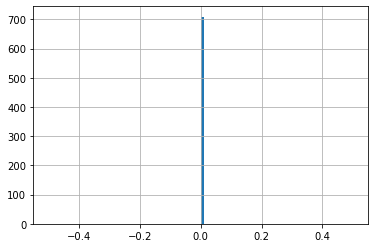

UPDATED_DATE
          id              updated_date  delta
137   237213  (2019-05-08, 2021-05-11)    734
577  1687633  (2019-06-05, 2021-05-12)    707
576  1720149  (2019-06-05, 2021-05-12)    707
578  1725275  (2019-06-05, 2021-05-12)    707
579  2178716  (2019-06-05, 2021-05-06)    701


DURATION
         id          duration   delta
137  237213     (nan, 4588.0)  4588.0
704  242851  (2460.0, 4860.0)  2400.0
45   250647  (1260.0, 3660.0)  2400.0
573  247962  (6000.0, 7035.0)  1035.0
385  248864  (4560.0, 5054.0)   494.0


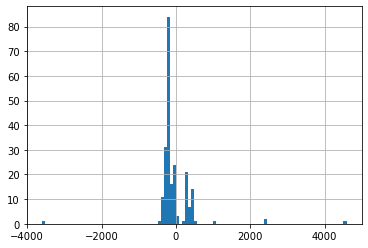

TITLE
         id                                              title  delta
564  248773  (Entrez sans Frapper Entrez sans Frapper, Entr...     24
33   250038  (JT 19h30 JT 19h30, JT 19h30 (Boucle de nuit) ...     17
456  251639  (JT 19h30 JT 19h30, JT 19h30 (Boucle de nuit) ...     17
427  251083  (JT 19h30 JT 19h30, JT 19h30 (Boucle de nuit) ...     17
437  250832  (JT 19h30 JT 19h30, JT 19h30 (Boucle de nuit) ...     17


RECOMMENDABLE_FROM
          id        recommendable_from  delta
137   237213  (2010-06-22, 2020-05-12)   3612
59   2067550  (2015-12-13, 2021-05-06)   1971
708  2585554  (2020-07-13, 2021-05-15)    306
92   2585189  (2020-07-10, 2021-05-08)    302
154  2668635  (2020-08-16, 2021-05-09)    266


RELATED_TO
          id                                         related_to  delta
167  2353616  ([{'id': '9927625', 'type': 'article'}, {'id':...      1
123  2608431       ([], [{'id': '9559360', 'type': 'article'}])      1
60   2558806  ([{'id': '10350865', 'type': 'article'}], [{'i...      1
0    2025081       ([{'id': '9011818', 'type': 'article'}], [])     -1
1    2172640       ([{'id': '9492692', 'type': 'article'}], [])     -1


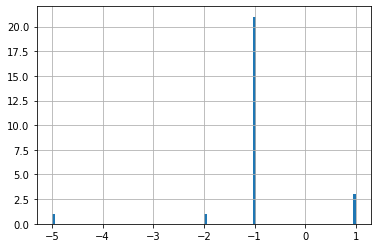

RECOMMENDABLE_UNTIL
         id       recommendable_until  delta
4   1809318  (2013-04-20, 2035-03-23)   8007
12  1845506  (2013-09-11, 2035-07-10)   7972
2   1807864  (2013-04-15, 2035-02-11)   7972
3   1841160  (2013-08-21, 2035-06-19)   7972
5   1805244  (2013-04-05, 2035-02-01)   7972


CASTING
         id    casting  delta
0   2025081  (nan, [])      0
1   2172640  (nan, [])      0
66  2667152  ([], nan)      0
29  2623265  ([], nan)      0
22  1803923  (nan, [])      0


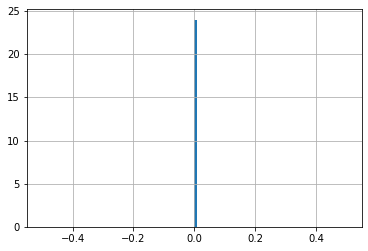

FLAGS
         id                           flags  delta
0   2025081  ({'prev': False, 'cur': True})      0
1   2172640  ({'prev': False, 'cur': True})      0
22  1803923  ({'prev': False, 'cur': True})      0
20  1807251  ({'prev': False, 'cur': True})      0
19  2172639  ({'prev': False, 'cur': True})      0


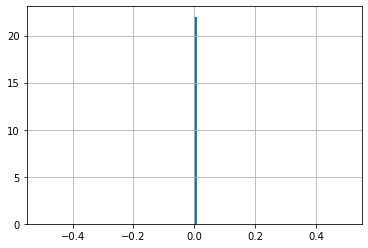

FILE
         id                                               file  delta
0   2025081  (nan, {'size': 41664042, 'filename': 'video_20...      4
11  2172620  (nan, {'size': 22009926, 'filename': 'video_21...      4
20  1807251  (nan, {'size': 25914660, 'filename': 'video_18...      4
19  2172639  (nan, {'size': 27028428, 'filename': 'video_21...      4
17  1813765  (nan, {'size': 33450666, 'filename': 'video_18...      4


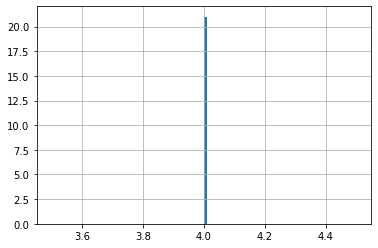

TAGS
          id                                               tags  delta
166  2685099  (nan, [bouge, bouge a la maison, etirement, et...      9
49   2653345  ([1976, amerique, archives sonuma, californie,...      1
133  2615334                              (nan, [peter boeckx])      1
0    2025081                                        ([jt], nan)     -1
1    2172640                                        ([jt], nan)     -1


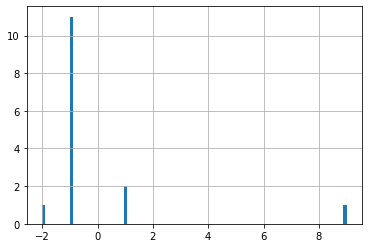

DESCRIPTION
          id                                        description  delta
518   284440  ( , L'humoriste Tamara Payne pour Chacun chez ...    775
519   284359  ( , Éric Le Bourhis pour son livre Florent Pag...    747
577  1687633  (Jupiler pro League - Journée 28, Les Liégeois...    596
36    284313  ( , L'acteur Antoine Duléry pour son livre Imi...    506
520   284312  ( , Typh Barrow pour la suite des Blind de The...    426


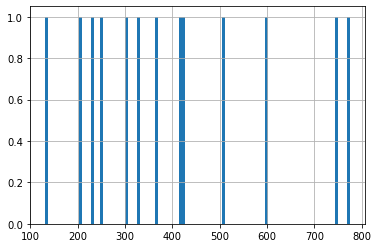

CONTENT_TYPE
          id      content_type  delta
137   237213   (nan, complete)      8
68   2532031  (extract, bonus)     -2
69   2532027  (extract, bonus)     -2
70   2532030  (extract, bonus)     -2
71   2532056  (extract, bonus)     -2


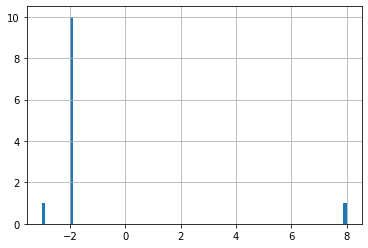

SUBTITLE
          id                                           subtitle  delta
166  2685099  (Bouge à la maison, Episode 70 : S'étirer les ...     29
578  1725275     (01 mai 2012, Pro League - PO1 - 7ème Journée)     20
576  1720149   (12 avril 2012, Pro League - PO1 - 3ème journée)     18
577  1687633         (04 mars 2012, Pro League - 28ème Journée)     14
59   2067550  (Football - Pro League J19, Pro League - 19ème...      1


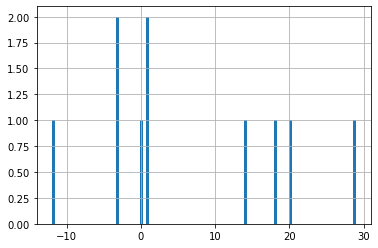

CATEGORY_FULLNAME
          id                          category_fullname  delta
52   2618650    (Radio > PURE, Divertissement > Humour)     11
124  2619836    (Radio > PURE, Divertissement > Humour)     11
126  2621367    (Radio > PURE, Divertissement > Humour)     11
647  2622764    (Radio > PURE, Divertissement > Humour)     11
137   237213  (Sans Chichis - Loisirs, Info > Journaux)     -7


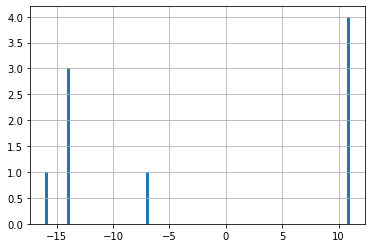

CATEGORY_IDS
          id          category_ids  delta
137   237213    ([2947], [129, 1])      1
52   2618650  ([26, 50], [40, 29])      0
124  2619836  ([26, 50], [40, 29])      0
126  2621367  ([26, 50], [40, 29])      0
647  2622764  ([26, 50], [40, 29])      0


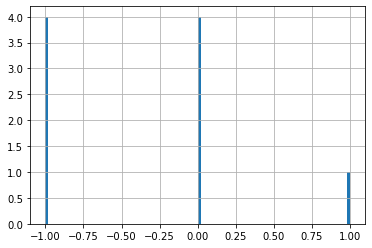

PROGRAM
          id                              program  delta
137   237213                   (nan, {'id': '5'})      1
49   2653345  ({'prev': '17307', 'cur': '19301'})      0
63   2661751  ({'prev': '17387', 'cur': '19301'})      0
64   2704485  ({'prev': '17387', 'cur': '19301'})      0
65   2661739  ({'prev': '17387', 'cur': '19301'})      0


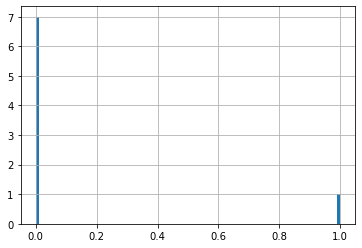

GEOLOCK
          id           geolock  delta
137   237213  (world, belgium)      2
59   2067550  (belgium, world)     -2
61   2136928  (belgium, world)     -2
62   2039284  (belgium, world)     -2
577  1687633  (belgium, world)     -2


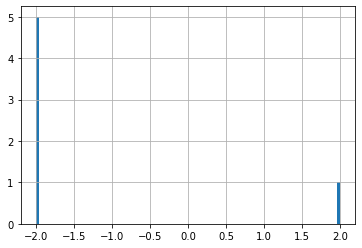

TYPE
         id             type  delta
137  237213  (article, live)     -3


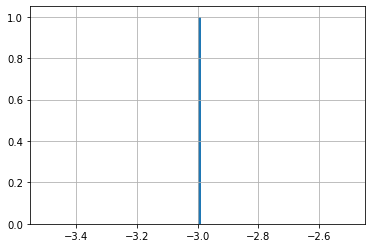

LANGUAGE
         id   language  delta
137  237213  (nan, fr)      2


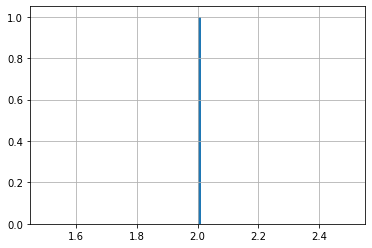

CONTENT
         id                                            content  delta
137  237213  (Encore du foot, me direz-vous mesdames. Mais ...  -1886


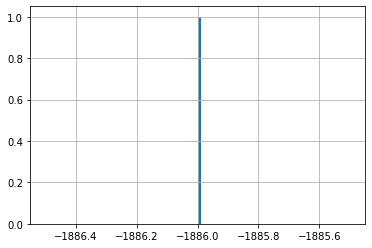

PROVIDER
         id      provider  delta
137  237213  (RTBF, CRYO)      0


CHANNEL
         id  channel  delta
137  237213  (TV, 1)     -1


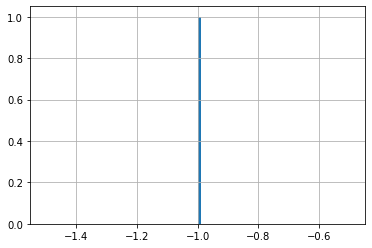

CREATED_DATE
         id              created_date  delta
137  237213  (2017-10-19, 2020-04-28)    922


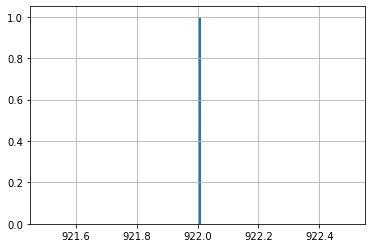

INTERNAL_ID
         id         internal_id  delta
137  237213  (109201, 11557393)      0


RECOMMENDABLE
         id  recommendable  delta
137  237213  (True, False)      0


In [26]:
for elem in list_elems_changed:
    df_dif_metadata['variable'] = df_dif_metadata['differences'].apply(lambda x: x[elem['variable']] if elem['variable'] in x else np.nan)
    df_temp = df_dif_metadata.loc[~df_dif_metadata['variable'].isna()].copy()
    df_temp[elem['variable']] = df_temp['variable'].apply(lambda x: x.values())    
    df_temp['delta'] = df_temp['variable'].apply(lambda x: calculate_differences(x))
    print(elem['variable'].upper())    
    df_temp['delta'].hist(bins=100)
    print(df_temp[['id',elem['variable'],'delta']].sort_values('delta', ascending=False).head())
    plt.show()

### Media *characteristics*

In [18]:
df_dev = df_data_reco.copy()

In [19]:
df_dev.count()

id          580927
database    580927
dtype: int64

In [ ]:
df_dev_ch = pd.read_sql_query("""select * from rtbfv2.media_features where id in ('{}')""".format("','".join([str(x) for x in df_dev['id']])), engine)
df_dev_ch['data'] = df_dev_ch.apply(lambda x: {'coarse_topics':x['coarse_topics'], 'entities':x['entities'], 'topics':x['topics'], **x[[x for x in df_dev_ch.columns if x not in ['id','coarse_topics','entities','topics']]].to_dict()}, axis=1)
df_dev_ch.head()

In [ ]:
df_de.count()

In [36]:
df_prod_ch = pd.read_sql_query("""SELECT * FROM rtbfv2.media_features m WHERE id in ('{}')""".format("','".join([str(x) for x in df_dev['id']])), engine_prod)
df_prod_ch['data'] = df_prod_ch.apply(lambda x: {'coarse_topics':x['coarse_topics'], 'entities':x['entities'], 'topics':x['topics'], **x[[x for x in df_prod_ch.columns if x not in ['id','coarse_topics','entities','topics']]].to_dict()}, axis=1)
df_prod_ch.head()

id   type data_source     source coarse_topics  \
0  1687633  video       media  textrazor            []   
1  1720149  video       media  textrazor            []   
2  1725275  video       media  textrazor            []   
3  1803923  video       media  textrazor            []   
4  1805244  video       media  textrazor            []   

                                              topics  \
0  [{'label': 'Association football', 'wikilink':...   
1  [{'label': 'Association football', 'wikilink':...   
2  [{'label': 'Association football', 'wikilink':...   
3  [{'label': 'Namur', 'wikilink': 'http://en.wik...   
4                                                 []   

                                            entities  \
0  [{'wikilink': '', 'entity_id': '28', 'english_...   
1  [{'wikilink': 'http://fr.wikipedia.org/wiki/Ch...   
2  [{'wikilink': '', 'entity_id': '2012', 'englis...   
3  [{'wikilink': 'http://fr.wikipedia.org/wiki/Na...   
4  [{'wikilink': '', 'entity_id': 'USA', 'english...   

                                         text_shasum  \
0  c4505e68f71d34249cf66694b0d692e88a1492ba6d6f13...   
1  77b30aa54b1eaeb9b1ed4eccf496416a3c66c55e1b60de...   
2  53c12dd077dd553547fa668b91e71ef9e5ce9550b6a46b...   
3  34021f185eb624dd0324eda19621d5971b58c0cd891125...   
4  1bda4526e2b19b86cf2244360e3bad855e71368e9de82f...   

                      created_date                     updated_date  \
0 2018-01-21 19:38:29.624998+00:00 2019-05-13 08:25:11.402954+00:00   
1 2018-01-21 19:38:28.230998+00:00 2019-05-12 16:29:54.121263+00:00   
2 2018-01-21 19:38:27.562702+00:00 2019-06-08 05:21:06.032329+00:00   
3 2018-01-21 19:38:18.263204+00:00 2019-06-09 01:41:05.552655+00:00   
4 2018-01-21 19:38:18.074042+00:00 2019-06-09 01:43:00.355766+00:00   

  deleted_date         ttl  internal_id  \
0         None  1558602006       683344   
1         None  1558539827       641921   
2         None  1560801525       641408   
3         None  1560801525       633853   
4         None  1560801525       633702   

                                                data  
0  {'coarse_topics': [], 'entities': [{'wikilink'...  
1  {'coarse_topics': [], 'entities': [{'wikilink'...  
2  {'coarse_topics': [], 'entities': [{'wikilink'...  
3  {'coarse_topics': [], 'entities': [{'wikilink'...  
4  {'coarse_topics': [], 'entities': [{'wikilink'...

In [37]:
df_comp_fe = df_dev_ch[['id','data']].merge(df_prod_ch[['id','data']], on='id', suffixes=['_current','_previous'])
df_comp_fe.head()

id                                       data_current  \
0  1687633  {'coarse_topics': [], 'entities': [{'wikilink'...   
1  1720149  {'coarse_topics': [], 'entities': [{'wikilink'...   
2  1725275  {'coarse_topics': [], 'entities': [{'wikilink'...   
3  1803923  {'coarse_topics': [], 'entities': [{'wikilink'...   
4  1805244  {'coarse_topics': [], 'entities': [{'wikilink'...   

                                       data_previous  
0  {'coarse_topics': [], 'entities': [{'wikilink'...  
1  {'coarse_topics': [], 'entities': [{'wikilink'...  
2  {'coarse_topics': [], 'entities': [{'wikilink'...  
3  {'coarse_topics': [], 'entities': [{'wikilink'...  
4  {'coarse_topics': [], 'entities': [{'wikilink'...

In [38]:
df_comp_fe['equal'] = df_comp_fe.apply(lambda x: 1 if x['data_current'] == x['data_previous'] else 0, axis=1)
df_comp_fe['equal'].unique()

array([1, 0])

In [39]:
df_comp_fe['differences'] = np.nan
df_tmp = df_comp_fe.loc[df_comp_fe['equal'] == 0].copy()
df_tmp['differences'] = df_tmp.apply(lambda x: get_differences('', x['data_previous'], x['data_current']), axis=1)
df_comp_fe.update(df_tmp)
df_dif_metadata_fe = df_comp_fe.loc[df_comp_fe['equal'] == 0].copy()

In [42]:
df_dif_metadata_fe.iloc[0]['differences']['entities']

{'prev': [{'wikilink': 'http://fr.wikipedia.org/wiki/Actualité',
   'entity_id': 'Actualité',
   'english_id': 'News',
   'freebase_id': '/m/05jhg',
   'wikidata_id': 'Q38926',
   'matched_text': 'actualité',
   'freebase_types': ['/tv/tv_genre',
    '/book/periodical_subject',
    '/book/magazine_genre',
    '/media_common/media_genre',
    '/book/book_subject',
    '/broadcast/genre',
    '/organization/organization_sector',
    '/broadcast/content',
    '/film/film_genre',
    '/education/field_of_study',
    '/organization/organization_type',
    '/media_common/quotation_subject',
    '/radio/radio_subject',
    '/internet/website_category',
    '/broadcast/radio_format'],
   'ending_position': 81,
   'relevance_score': 0.07501,
   'confidence_score': 0.9743,
   'starting_position': 72}],
 'cur': [{'wikilink': 'http://fr.wikipedia.org/wiki/Rédacteur_en_chef',
   'entity_id': 'Rédacteur en chef',
   'english_id': 'Editor-in-chief',
   'freebase_id': '/m/02wk2cy',
   'wikidata_id': '

In [44]:
[x['entity_id'] for x in df_dif_metadata_fe.iloc[0]['data_current']['entities']]

['Rédacteur en chef',
 '5',
 '2010',
 '2006',
 '32',
 'Hervé Mahoux Cover',
 'Canal+',
 'Pascal Boniface',
 'Hervé Mathoux',
 'Football',
 'Football',
 'Coupe du monde de football',
 'Coupe du monde de football',
 'Coupe du monde de football',
 'Football',
 'Coupe du monde de football',
 'Coupe du monde de football',
 'Géopolitique',
 'Corée',
 'Anglais',
 "Équipe d'Argentine de football",
 'Mondial',
 'Tchèques',
 'Mondial',
 'Coupe du monde de football',
 'Coupe du monde de football',
 'Institut des relations internationales',
 'Marie-Claire Martens',
 'Paraguay',
 'Éditions Larousse',
 'Mondialisation',
 'Hervé Mathoux',
 'Pays-Bas',
 'Pascal Boniface',
 'Slovaquie',
 'Serbie',
 'Pascal Boniface',
 'Canal+',
 'Afrique',
 'Brésil',
 'Relations internationales',
 'Football',
 'Football',
 'Football',
 'France',
 'Afrique',
 'Football',
 'Canal Football Club',
 'Football',
 'Barbosa',
 "Équipe d'Afrique du Sud de football",
 'Football',
 'Nouvelle-Zélande',
 'Haka']

In [45]:
[x['entity_id'] for x in df_dif_metadata_fe.iloc[0]['data_previous']['entities']]

['Actualité']

In [53]:
df_dif_metadata_fe['differences_key'] = df_dif_metadata_fe['differences'].apply(lambda x: list(x.keys()))
elems_changed_fe = {x: 0 for x in set([item for elem in list(df_dif_metadata_fe['differences_key']) for item in elem])}
df_dif_metadata_fe['differences_key'].apply(lambda x: [add_elem_changed(i, elems_changed_fe) for i in x])
elems_changed_fe

{'created_date': 2,
 'internal_id': 2,
 'updated_date': 7,
 'ttl': 7,
 'type': 2,
 'entities': 7,
 'text_shasum': 2,
 'topics': 7}

In [54]:
list_elems_changed_fe = [{'variable':x, 'count': elems_changed_fe[x]} for x in elems_changed_fe.keys()]
list_elems_changed_fe.sort(key=lambda x: x.get('count'), reverse=True)
list_elems_changed_fe

[{'variable': 'updated_date', 'count': 7},
 {'variable': 'ttl', 'count': 7},
 {'variable': 'entities', 'count': 7},
 {'variable': 'topics', 'count': 7},
 {'variable': 'created_date', 'count': 2},
 {'variable': 'internal_id', 'count': 2},
 {'variable': 'type', 'count': 2},
 {'variable': 'text_shasum', 'count': 2}]

---
#### Differences between media *metadata*

UPDATED_DATE
          id                                       updated_date  delta
64    237213  (2020-12-28 09:03:13.544897+00:00, 2019-05-14 ...      0
67    237213  (2019-05-14 09:58:35.011717+00:00, 2020-12-28 ...      0
133   240601  (2020-06-04 01:10:22.140588+00:00, 2021-05-17 ...      0
142   240737  (2020-05-28 17:11:54.829201+00:00, 2021-05-17 ...      0
653  2623265            (NaT, 2021-05-17 01:08:25.042541+00:00)      0


TTL
          id                       ttl  delta
64    237213  (1609970422, 1558690367)      0
67    237213  (1558690367, 1609970422)      0
133   240601  (1592085612, 1622042828)      0
142   240737  (1591524012, 1622042828)      0
653  2623265  (1587023365, 1622042828)      0


ENTITIES
          id                                           entities  delta
64    237213  ([{'wikilink': 'http://fr.wikipedia.org/wiki/A...     53
133   240601  ([{'wikilink': 'http://fr.wikipedia.org/wiki/R...      0
142   240737  ([{'wikilink': 'http://fr.wikipedia.org/wiki/E...      0
654  2623407  ([{'wikilink': 'http://fr.wikipedia.org/wiki/L...      0
655  2623452  ([{'wikilink': 'http://fr.wikipedia.org/wiki/B...      0


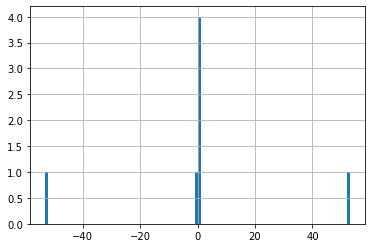

TOPICS
          id                                             topics  delta
64    237213  ([{'label': 'Communication', 'wikilink': 'http...    116
653  2623265  ([{'label': 'Coronaviridae', 'wikilink': 'http...     85
655  2623452  ([{'label': 'YouTube', 'wikilink': 'http://en....     22
133   240601  ([{'label': 'Ivan Drago', 'wikilink': 'http://...      8
142   240737  ([{'label': 'Music', 'wikilink': 'http://en.wi...      2


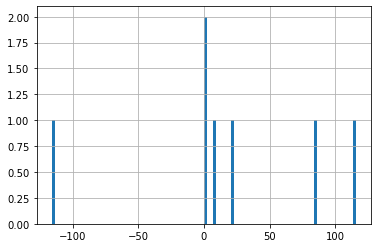

CREATED_DATE
        id                                       created_date  delta
64  237213  (2020-06-04 04:56:52.007779+00:00, 2018-01-21 ...      0
67  237213  (2018-01-21 19:35:56.165206+00:00, 2020-06-04 ...      0


INTERNAL_ID
        id         internal_id  delta
64  237213  (16250560, 530334)      0
67  237213  (530334, 16250560)      0


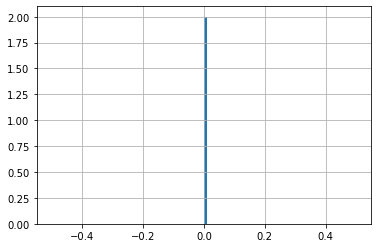

TYPE
        id             type  delta
64  237213  (live, article)      3
67  237213  (article, live)     -3


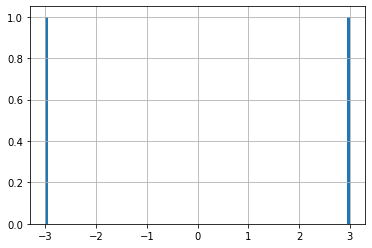

TEXT_SHASUM
        id                                        text_shasum  delta
64  237213  (fa86fa216e6655eb2850cd50b2cc2f75e1b79685c70a0...      0
67  237213  (14cc94408efc66075418bc91bcd1b4ea4aced7b5d2c72...      0


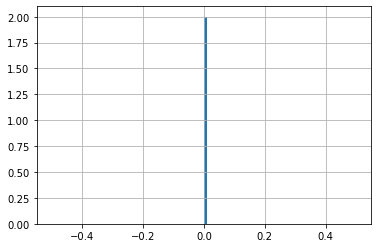

In [55]:
for elem in list_elems_changed_fe:
    df_dif_metadata_fe['variable'] = df_dif_metadata_fe['differences'].apply(lambda x: x[elem['variable']] if elem['variable'] in x else np.nan)
    df_temp = df_dif_metadata_fe.loc[~df_dif_metadata_fe['variable'].isna()].copy()
    df_temp[elem['variable']] = df_temp['variable'].apply(lambda x: x.values())    
    df_temp['delta'] = df_temp['variable'].apply(lambda x: calculate_differences(x))
    print(elem['variable'].upper())    
    df_temp['delta'].hist(bins=100)
    print(df_temp[['id',elem['variable'],'delta']].sort_values('delta', ascending=False).head())
    plt.show()

In [16]:
df_dev.head()

id   type                                           metadata  \
0  1841160  video  {'file': {'size': 31471958, 'filename': 'video...   
1  2172640  video  {'file': {'size': 3149548, 'filename': 'video_...   
2  1807864  video  {'file': {'size': 37165726, 'filename': 'video...   
3  2025081  video  {'file': {'size': 41664042, 'filename': 'video...   
4  1809318  video  {'file': {'size': 20709821, 'filename': 'video...   

   recommendable recommendable_from recommendable_until geolock target_code  \
0           True         2013-07-23          2035-06-19   world           G   
1           True         2017-01-01          2027-01-01   world           G   
2           True         2013-03-17          2035-02-11   world           G   
3           True         2015-06-20          2035-06-20   world           G   
4           True         2013-03-22          2035-03-23   world           G   

  created_date updated_date deleted_date  internal_id  important provider  \
0   2017-08-07   2021-05-04         None        38816          2     CRYO   
1   2017-08-07   2021-04-30         None       989081          2    DALET   
2   2017-08-07   2021-04-30         None       105593          2     CRYO   
3   2017-08-07   2021-05-04         None        56819          2    DALET   
4   2017-08-07   2021-05-04         None       960944          2     CRYO   

                                                data  
0  {'file': {'size': 31471958, 'filename': 'video...  
1  {'file': {'size': 3149548, 'filename': 'video_...  
2  {'file': {'size': 37165726, 'filename': 'video...  
3  {'file': {'size': 41664042, 'filename': 'video...  
4  {'file': {'size': 20709821, 'filename': 'video...

In [31]:
df_dev['internal_id']

0        105593
1         56819
2         38816
3        989081
4        960944
         ...   
703    12621828
704    12622992
705    12626423
706    12626420
707    12707140
Name: internal_id, Length: 708, dtype: int64

In [30]:
df_dev_tr = pd.read_sql_query("""select * from rtbfv2.transcription where internal_id in ('{}')""".format("','".join([str(x) for x in df_dev['internal_id']])), engine)
df_dev_tr.head()

id   type         source  \
0  2290432  video  s2t_limecraft   

                                transcription_chunks  \
0  [{'speech_annotation': {'parts': [{'type': 'LE...   

                                         file_shasum  \
0  aed2843d21613f43a24e9d3bc327bfe7174d47cab442bb...   

                      created_date updated_date deleted_date   ttl frame_rate  \
0 2017-12-20 22:45:28.567361+00:00         None         None  None       None   

   internal_id  
0         2202

In [18]:
df_prod_tr = pd.read_sql_query("""SELECT * FROM rtbfv2.transcription m WHERE internal_id in ('{}')""".format("','".join([str(x) for x in df_dev['internal_id']])), engine_prod)
df_prod_tr.head()

id   type         source  \
0  2290432  video  s2t_limecraft   

                                transcription_chunks  \
0  [{'speech_annotation': {'parts': [{'type': 'LE...   

                                         file_shasum  \
0  aed2843d21613f43a24e9d3bc327bfe7174d47cab442bb...   

                      created_date updated_date deleted_date   ttl frame_rate  \
0 2017-12-20 22:45:28.567361+00:00         None         None  None       None   

   internal_id  
0         2202